In [ ]:
#Beating DeepFood
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-51661545-ab33-e106-2349-e28dbb924b12)


In [ ]:
# !pip install tensorflow==2.4
import tensorflow as tf
tf.__version__

'2.4.0'

In [ ]:
#load helper functions from github 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-04 01:29:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-04 01:29:11 (74.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,compare_historys

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds


In [ ]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
#load food101 dataset

(train_data,test_data),ds_info = tfds.load(name = "food101",
                                           split = ["train","validation"],
                                           shuffle_files = True,
                                           as_supervised = True,
                                           with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteDG51X7/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteDG51X7/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
#get class names

class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
take_one = train_data.take(1)

In [ ]:
for image,label in take_one:
  print(image.shape,image.dtype,label)

(512, 512, 3) <dtype: 'uint8'> tf.Tensor(18, shape=(), dtype=int64)


In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[170, 193, 165],
        [175, 198, 170],
        [187, 209, 186],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       [[169, 185, 159],
        [169, 184, 161],
        [171, 189, 167],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       [[166, 171, 151],
        [161, 166, 146],
        [158, 165, 147],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       ...,

       [[143, 131, 105],
        [143, 131, 105],
        [141, 132, 103],
        ...,
        [152, 131, 104],
        [153, 129, 103],
        [151, 127, 101]],

       [[139, 129, 102],
        [138, 128, 101],
        [137, 128,  99],
        ...,
        [150, 126, 100],
        [151, 125, 100],
        [152, 126,  99]],

       [[133, 123,  96],
        [134, 124,  97],
        [136, 127,  98],
        ...,
        [149, 125,  9

(-0.5, 511.5, 511.5, -0.5)

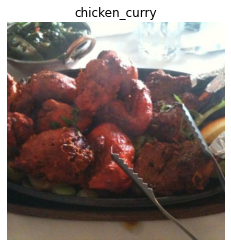

In [ ]:
#plot image tensor
import matplotlib.pyplot as plt
import numpy

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [ ]:
#TF likes batched, normalized/scaled  datasets
#right now the loaded data is in tuples of (image,label) for both train and test
def preprocess_img (image,label,img_shape = 224):
  image = tf.image.resize(image, [img_shape, img_shape]) 
  return tf.cast(image, tf.float32), label

In [ ]:
#preprocess a sample

preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[170.5051  , 188.59184 , 163.11736 ],
        [187.9898  , 206.82143 , 186.91837 ],
        [208.97958 , 225.69388 , 212.7653  ],
        ...,
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ]],

       [[155.02551 , 149.47958 , 134.38776 ],
        [149.11224 , 149.47958 , 137.11734 ],
        [153.97449 , 162.87245 , 152.42857 ],
        ...,
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ]],

       [[126.99999 , 106.21939 ,  99.79082 ],
        [119.591835, 108.19388 , 102.12245 ],
        [118.66837 , 121.42857 , 113.42857 ],
        ...,
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ]],

       ...,

       [[139.71938 , 125.71938 ,  98.71938 ],
        [137.

In [ ]:
#batch and prepare dataset(parallelize) pipeline using image_dataset_from_directory
#AUTOTUNE will utilize all CPU/GPU power 
#shuffle train_data and turn into batches
#we mapped our preprocess_img func to full train_data and used AUTOTUNE to make the process fast 

train_data = train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
train_data,test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [ ]:
#create tensorboard callback
from helper_functions import create_tensorboard_callback

checkpoint_path ="model_checkpoints/cp.pkt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_acc",
                                                      save_best_only = True,
                                                      sve_weights_only = True,
                                                      verbose = 0)

In [ ]:
#setup mixed precision training

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
#build feature extraction model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape,name="input_layer")
x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax",dtype = tf.float32,name = "softmax_float32")(x)   # turn dtype to float32 during output as mixed pricision stores variable and outputs in float32 better
model = tf.keras.Model(inputs,outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])  #since labels are in int we use sparse , if it were onehot encoded we should use categorical

model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in model.layers[1].layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

In [ ]:
history_101_food_classes_features_extract = model.fit(train_data,
                                                      epochs = 3,
                                                      steps_per_epoch = len(train_data),
                                                      validation_data = test_data,
                                                      validation_steps = int(0.15 * len(test_data)),
                                                      callbacks = [create_tensorboard_callback(dir_name= "training_logs",
                                                                                              experiment_name = "efficientnetB0_101_food_classes"),
                                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetB0_101_food_classes/20220204-014140
Epoch 1/3
2368/2368 [==============================] - 187s 72ms/step - loss: 2.3229 - accuracy: 0.4689 - val_loss: 1.2260 - val_accuracy: 0.6708


Epoch 2/3
2368/2368 [==============================] - 169s 70ms/step - loss: 1.3081 - accuracy: 0.6623 - val_loss: 1.1157 - val_accuracy: 0.7029


Epoch 3/3
2368/2368 [==============================] - 176s 73ms/step - loss: 1.1483 - accuracy: 0.7004 - val_loss: 1.0828 - val_accuracy: 0.7066


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 46s 59ms/step - loss: 1.0915 - accuracy: 0.7069


[1.091526746749878, 0.7068910598754883]

TO DOs

In [ ]:
#save model to a file 
model.save("drive/MyDrive/tensorflow_saved_models/101_food_milestone_model")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_saved_models/101_food_milestone_model/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_saved_models/101_food_milestone_model/assets


In [ ]:
#load model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_saved_models/101_food_milestone_model")

In [ ]:
#evaluate loaded model
loaded_loss,loaded_accuracy = loaded_model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 50s 63ms/step - loss: 1.0915 - accuracy: 0.7069


(1.0915277004241943, 0.7068910598754883)

In [ ]:
for layer in loaded_model.layers[1].layers:
  print(layer.trainable,layer.name,layer.dtype_policy)

True input_1 <Policy "float32">
True rescaling <Policy "mixed_float16">
True normalization <Policy "float32">
True stem_conv_pad <Policy "mixed_float16">
True stem_conv <Policy "mixed_float16">
True stem_bn <Policy "mixed_float16">
True stem_activation <Policy "mixed_float16">
True block1a_dwconv <Policy "mixed_float16">
True block1a_bn <Policy "mixed_float16">
True block1a_activation <Policy "mixed_float16">
True block1a_se_squeeze <Policy "mixed_float16">
True block1a_se_reshape <Policy "mixed_float16">
True block1a_se_reduce <Policy "mixed_float16">
True block1a_se_expand <Policy "mixed_float16">
True block1a_se_excite <Policy "mixed_float16">
True block1a_project_conv <Policy "mixed_float16">
True block1a_project_bn <Policy "mixed_float16">
True block2a_expand_conv <Policy "mixed_float16">
True block2a_expand_bn <Policy "mixed_float16">
True block2a_expand_activation <Policy "mixed_float16">
True block2a_dwconv_pad <Policy "mixed_float16">
True block2a_dwconv <Policy "mixed_float16

In [ ]:
#download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip



--2022-02-04 02:11:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  63.1MB/s    in 0.3s    

2022-02-04 02:11:20 (63.1 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
!mkdir downloaded_gs_model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
downloaded_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
downloaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
downloaded_model.evaluate(test_data)

790/790 [==============================] - 51s 61ms/step - loss: 1.0881 - accuracy: 0.7065


[1.0881279706954956, 0.7064950466156006]

In [ ]:
base_model.trainable = True

# for layer in base_model.layers[:-10]:
#   layer.trainable = False

downloaded_model.compile(loss = "sparse_categorical_crossentropy",
                         optimizer = tf.keras.optimizers.Adam(0.0001),
                         metrics = ["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss',patience=3)

In [ ]:
checkpoint_path ="fine_tuning_model_checkpoints/cp.pkt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_acc",
                                                      save_best_only = True,
                                                      sve_weights_only = True,
                                                      verbose = 0)

In [ ]:
for layer in downloaded_model.layers[1].layers:
  print(layer.trainable,layer.name,layer.dtype_policy)

In [ ]:
fine_tune_epochs = 5+95

history_fine_tuned_downloaded_model = downloaded_model.fit(train_data,
                                                           epochs = fine_tune_epochs,
                                                           steps_per_epoch = len(train_data),
                                                           validation_data = test_data,
                                                           validation_steps = int(0.15 * len(test_data)),
                                                           initial_epoch=history_101_food_classes_features_extract.epoch[-1],
                                                           callbacks = [create_tensorboard_callback(dir_name= "training_logs",
                                                                                              experiment_name = "efficientnetB0_101_food_classes"),
                                                                        model_checkpoint, early_stopping])


Saving TensorBoard log files to: training_logs/efficientnetB0_101_food_classes/20220204-025517
Epoch 3/100
2368/2368 [==============================] - 331s 130ms/step - loss: 0.9833 - accuracy: 0.7363 - val_loss: 0.7917 - val_accuracy: 0.7762


Epoch 4/100
2368/2368 [==============================] - 297s 125ms/step - loss: 0.5854 - accuracy: 0.8378 - val_loss: 0.7952 - val_accuracy: 0.7844


Epoch 5/100
2368/2368 [==============================] - 295s 124ms/step - loss: 0.3299 - accuracy: 0.9079 - val_loss: 0.8237 - val_accuracy: 0.7860


Epoch 6/100
2368/2368 [==============================] - 299s 126ms/step - loss: 0.1679 - accuracy: 0.9528 - val_loss: 0.9709 - val_accuracy: 0.7836


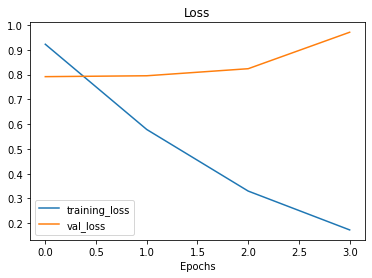

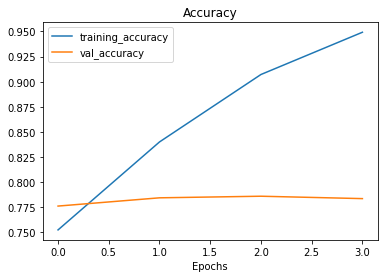

In [ ]:
 plot_loss_curves(history_fine_tuned_downloaded_model)

In [ ]:
downloaded_model.save("drive/MyDrive/tensorflow_saved_models/101_food_milestone_model+all_layers")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_saved_models/101_food_milestone_model+all_layers/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_saved_models/101_food_milestone_model+all_layers/assets


In [ ]:
downloaded_model.evaluate(test_data)

790/790 [==============================] - 51s 64ms/step - loss: 0.9969 - accuracy: 0.7767


[0.9968550205230713, 0.7767128944396973]

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2022-02-04 03:22:50.338829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0